### Notebook for the inference of cell-cell communications on Healthy-CTRL data using `LIANA+`

- **Developed by**: Carlos Talavera-López
- **Würzburg Institute for Systems Immunology, Faculty of Medicine, Julius-Maximilian-Universität Würzburg**
- **Created**: 231109
- **Latest version**: 240508

### Import required modules

In [1]:
import anndata
import numpy as np
import liana as li
import pandas as pd
import scanpy as sc

from liana.mt import rank_aggregate
from liana.method import singlecellsignalr, connectome, cellphonedb, natmi, logfc, cellchat, geometric_mean

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


### Set up working environment

In [2]:
sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.set_figure_params(dpi = 180, color_map = 'magma_r', dpi_save = 300, vector_friendly = True, format = 'svg')

-----
anndata     0.10.7
scanpy      1.10.1
-----
PIL                 9.3.0
appnope             0.1.4
asttokens           NA
comm                0.2.2
cycler              0.12.1
cython_runtime      NA
dateutil            2.9.0.post0
debugpy             1.8.1
decorator           5.1.1
docrep              0.3.2
executing           2.0.1
h5py                3.11.0
ipykernel           6.29.4
ipywidgets          8.1.2
jedi                0.19.1
joblib              1.4.2
kiwisolver          1.4.5
legacy_api_wrap     NA
liana               1.1.0
llvmlite            0.42.0
matplotlib          3.8.4
mizani              0.11.2
mpl_toolkits        NA
mudata              0.2.3
natsort             8.4.0
numba               0.59.1
numpy               1.26.4
packaging           24.0
pandas              2.2.2
parso               0.8.4
patsy               0.5.6
platformdirs        4.2.1
plotnine            0.13.5
prompt_toolkit      3.0.43
psutil              5.9.8
pure_eval           0.2.2
pydev_ipyth

### Read in data

In [3]:
adata_all = sc.read_h5ad('../../../data/Marburg_cell_states_locked_ctl231212.raw.h5ad') 
adata_all

AnnData object with n_obs × n_vars = 97573 × 27208
    obs: 'sex', 'age', 'ethnicity', 'PaCO2', 'donor', 'infection', 'disease', 'SMK', 'illumina_stimunr', 'bd_rhapsody', 'n_genes', 'doublet_scores', 'predicted_doublets', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'condition', 'sample_group', 'IAV_score', 'group', 'Viral_score', 'cell_type', 'cell_states', 'leiden', 'cell_compartment', '_scvi_batch', '_scvi_labels', 'C_scANVI', 'viral_counts', 'infected_status'
    var: 'mt', 'ribo'
    uns: 'cell_states_colors', 'disease_colors', 'group_colors', 'infected_status_colors', 'infection_colors'
    obsm: 'X_scANVI', 'X_scVI', 'X_umap'

### Subset conditions

In [4]:
adata = adata_all[adata_all.obs['group'].isin(['healthy_iav'])]
adata

View of AnnData object with n_obs × n_vars = 22687 × 27208
    obs: 'sex', 'age', 'ethnicity', 'PaCO2', 'donor', 'infection', 'disease', 'SMK', 'illumina_stimunr', 'bd_rhapsody', 'n_genes', 'doublet_scores', 'predicted_doublets', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'condition', 'sample_group', 'IAV_score', 'group', 'Viral_score', 'cell_type', 'cell_states', 'leiden', 'cell_compartment', '_scvi_batch', '_scvi_labels', 'C_scANVI', 'viral_counts', 'infected_status'
    var: 'mt', 'ribo'
    uns: 'cell_states_colors', 'disease_colors', 'group_colors', 'infected_status_colors', 'infection_colors'
    obsm: 'X_scANVI', 'X_scVI', 'X_umap'

### Check `LIANA+` available methods

In [5]:
li.mt.show_methods()

,Method Name,Magnitude Score,Specificity Score,Reference
0,CellPhoneDB,lr_means,cellphone_pvals,"Efremova, M., Vento-Tormo, M., Teichmann, S.A...."
0,Connectome,expr_prod,scaled_weight,"Raredon, M.S.B., Yang, J., Garritano, J., Wang..."
0,log2FC,None,lr_logfc,"Dimitrov, D., Türei, D., Garrido-Rodriguez, M...."
0,NATMI,expr_prod,spec_weight,"Hou, R., Denisenko, E., Ong, H.T., Ramilowski,..."
0,SingleCellSignalR,lrscore,None,"Cabello-Aguilar, S., Alame, M., Kon-Sun-Tack, ..."
0,Rank_Aggregate,magnitude_rank,specificity_rank,"Dimitrov, D., Türei, D., Garrido-Rodriguez, M...."
0,Geometric Mean,lr_gmeans,gmean_pvals,CellPhoneDBv2's permutation approach applied t...
0,scSeqComm,inter_score,None,"Baruzzo, G., Cesaro, G., Di Camillo, B. 2022. ..."
0,CellChat,lr_probs,cellchat_pvals,"Jin, S., Guerrero-Juarez, C.F., Zhang, L., Cha..."


### Run aggregated estimate 

In [6]:
li.mt.rank_aggregate(adata, groupby = 'cell_states', expr_prop = 0.1, verbose = True, use_raw = False)
adata.uns['liana_res'].head()

Using `.X`!
/Users/cartalop/miniforge3/envs/liana+/lib/python3.11/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
105 features of mat are empty, they will be removed.
Make sure that normalized counts are passed!
/Users/cartalop/miniforge3/envs/liana+/lib/python3.11/site-packages/liana/method/_pipe_utils/_pre.py:150: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/Users/cartalop/miniforge3/envs/liana+/lib/python3.11/site-packages/liana/method/_pipe_utils/_pre.py:153: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
['NC_026431.1', 'NC_026432.1', 'NC_026433.1', 'NC_026434.1', 'NC_026435.1', 'NC_026436.1', 'NC_026437.1', 'NC_026438.1'] contain `_`. Consider replacing those!
U

Generating ligand-receptor stats for 22687 samples and 1683 features
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


/Users/cartalop/miniforge3/envs/liana+/lib/python3.11/site-packages/liana/method/sc/_liana_pipe.py:256: ImplicitModificationWarning: Setting element `.layers['scaled']` of view, initializing view as actual.
/Users/cartalop/miniforge3/envs/liana+/lib/python3.11/site-packages/liana/method/sc/_liana_pipe.py:354: RuntimeWarning: overflow encountered in power


Assuming that counts were `natural` log-normalized!


/Users/cartalop/miniforge3/envs/liana+/lib/python3.11/site-packages/liana/method/sc/_liana_pipe.py:348: RuntimeWarning: invalid value encountered in subtract
/Users/cartalop/miniforge3/envs/liana+/lib/python3.11/site-packages/liana/method/sc/_liana_pipe.py:348: RuntimeWarning: invalid value encountered in subtract
/Users/cartalop/miniforge3/envs/liana+/lib/python3.11/site-packages/liana/method/sc/_liana_pipe.py:348: RuntimeWarning: invalid value encountered in subtract
/Users/cartalop/miniforge3/envs/liana+/lib/python3.11/site-packages/liana/method/sc/_liana_pipe.py:348: RuntimeWarning: invalid value encountered in subtract
/Users/cartalop/miniforge3/envs/liana+/lib/python3.11/site-packages/liana/method/sc/_liana_pipe.py:348: RuntimeWarning: invalid value encountered in subtract
/Users/cartalop/miniforge3/envs/liana+/lib/python3.11/site-packages/liana/method/sc/_liana_pipe.py:348: RuntimeWarning: invalid value encountered in subtract
/Users/cartalop/miniforge3/envs/liana+/lib/python3.1

Running CellPhoneDB


100%|██████████| 1000/1000 [00:42<00:00, 23.36it/s]


Running Connectome
Running log2FC


/Users/cartalop/miniforge3/envs/liana+/lib/python3.11/site-packages/numpy/core/_methods.py:118: RuntimeWarning: invalid value encountered in reduce


Running NATMI
Running SingleCellSignalR


/Users/cartalop/miniforge3/envs/liana+/lib/python3.11/site-packages/liana/method/sc/_rank_aggregate.py:151: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.


,source,target,ligand_complex,receptor_complex,lr_means,cellphone_pvals,expr_prod,scaled_weight,lr_logfc,spec_weight,lrscore,specificity_rank,magnitude_rank
360652,MUC5B+Goblet,ifn_Goblet,SLPI,PLSCR1,538.594971,0.0,36883.062500,2.194347,NaN,0.007827,0.992102,NaN,1.248235e-11
347592,MUC5B+Goblet,KRT16+SupraB,SLPI,PLSCR1,537.321716,0.0,34230.117188,2.090181,NaN,0.007264,0.991804,NaN,1.123410e-10
355932,MUC5B+Goblet,SERPINE1+Basal,SLPI,PLSCR1,537.207153,0.0,33991.453125,2.080811,NaN,0.007213,0.991776,NaN,1.997171e-10
826987,mixed_Goblet2,ifn_Goblet,SLPI,PLSCR1,529.484314,0.0,36237.960938,2.167610,NaN,0.007690,0.992033,NaN,7.988660e-10
814266,mixed_Goblet2,KRT16+SupraB,SLPI,PLSCR1,528.211060,0.0,33631.417969,2.063444,NaN,0.007137,0.991732,NaN,1.011064e-09


In [7]:
rank_aggregate.describe()

Rank_Aggregate returns `magnitude_rank`, `specificity_rank`. magnitude_rank and specificity_rank respectively represent an aggregate of the `magnitude`- and `specificity`-related scoring functions from the different methods.


Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


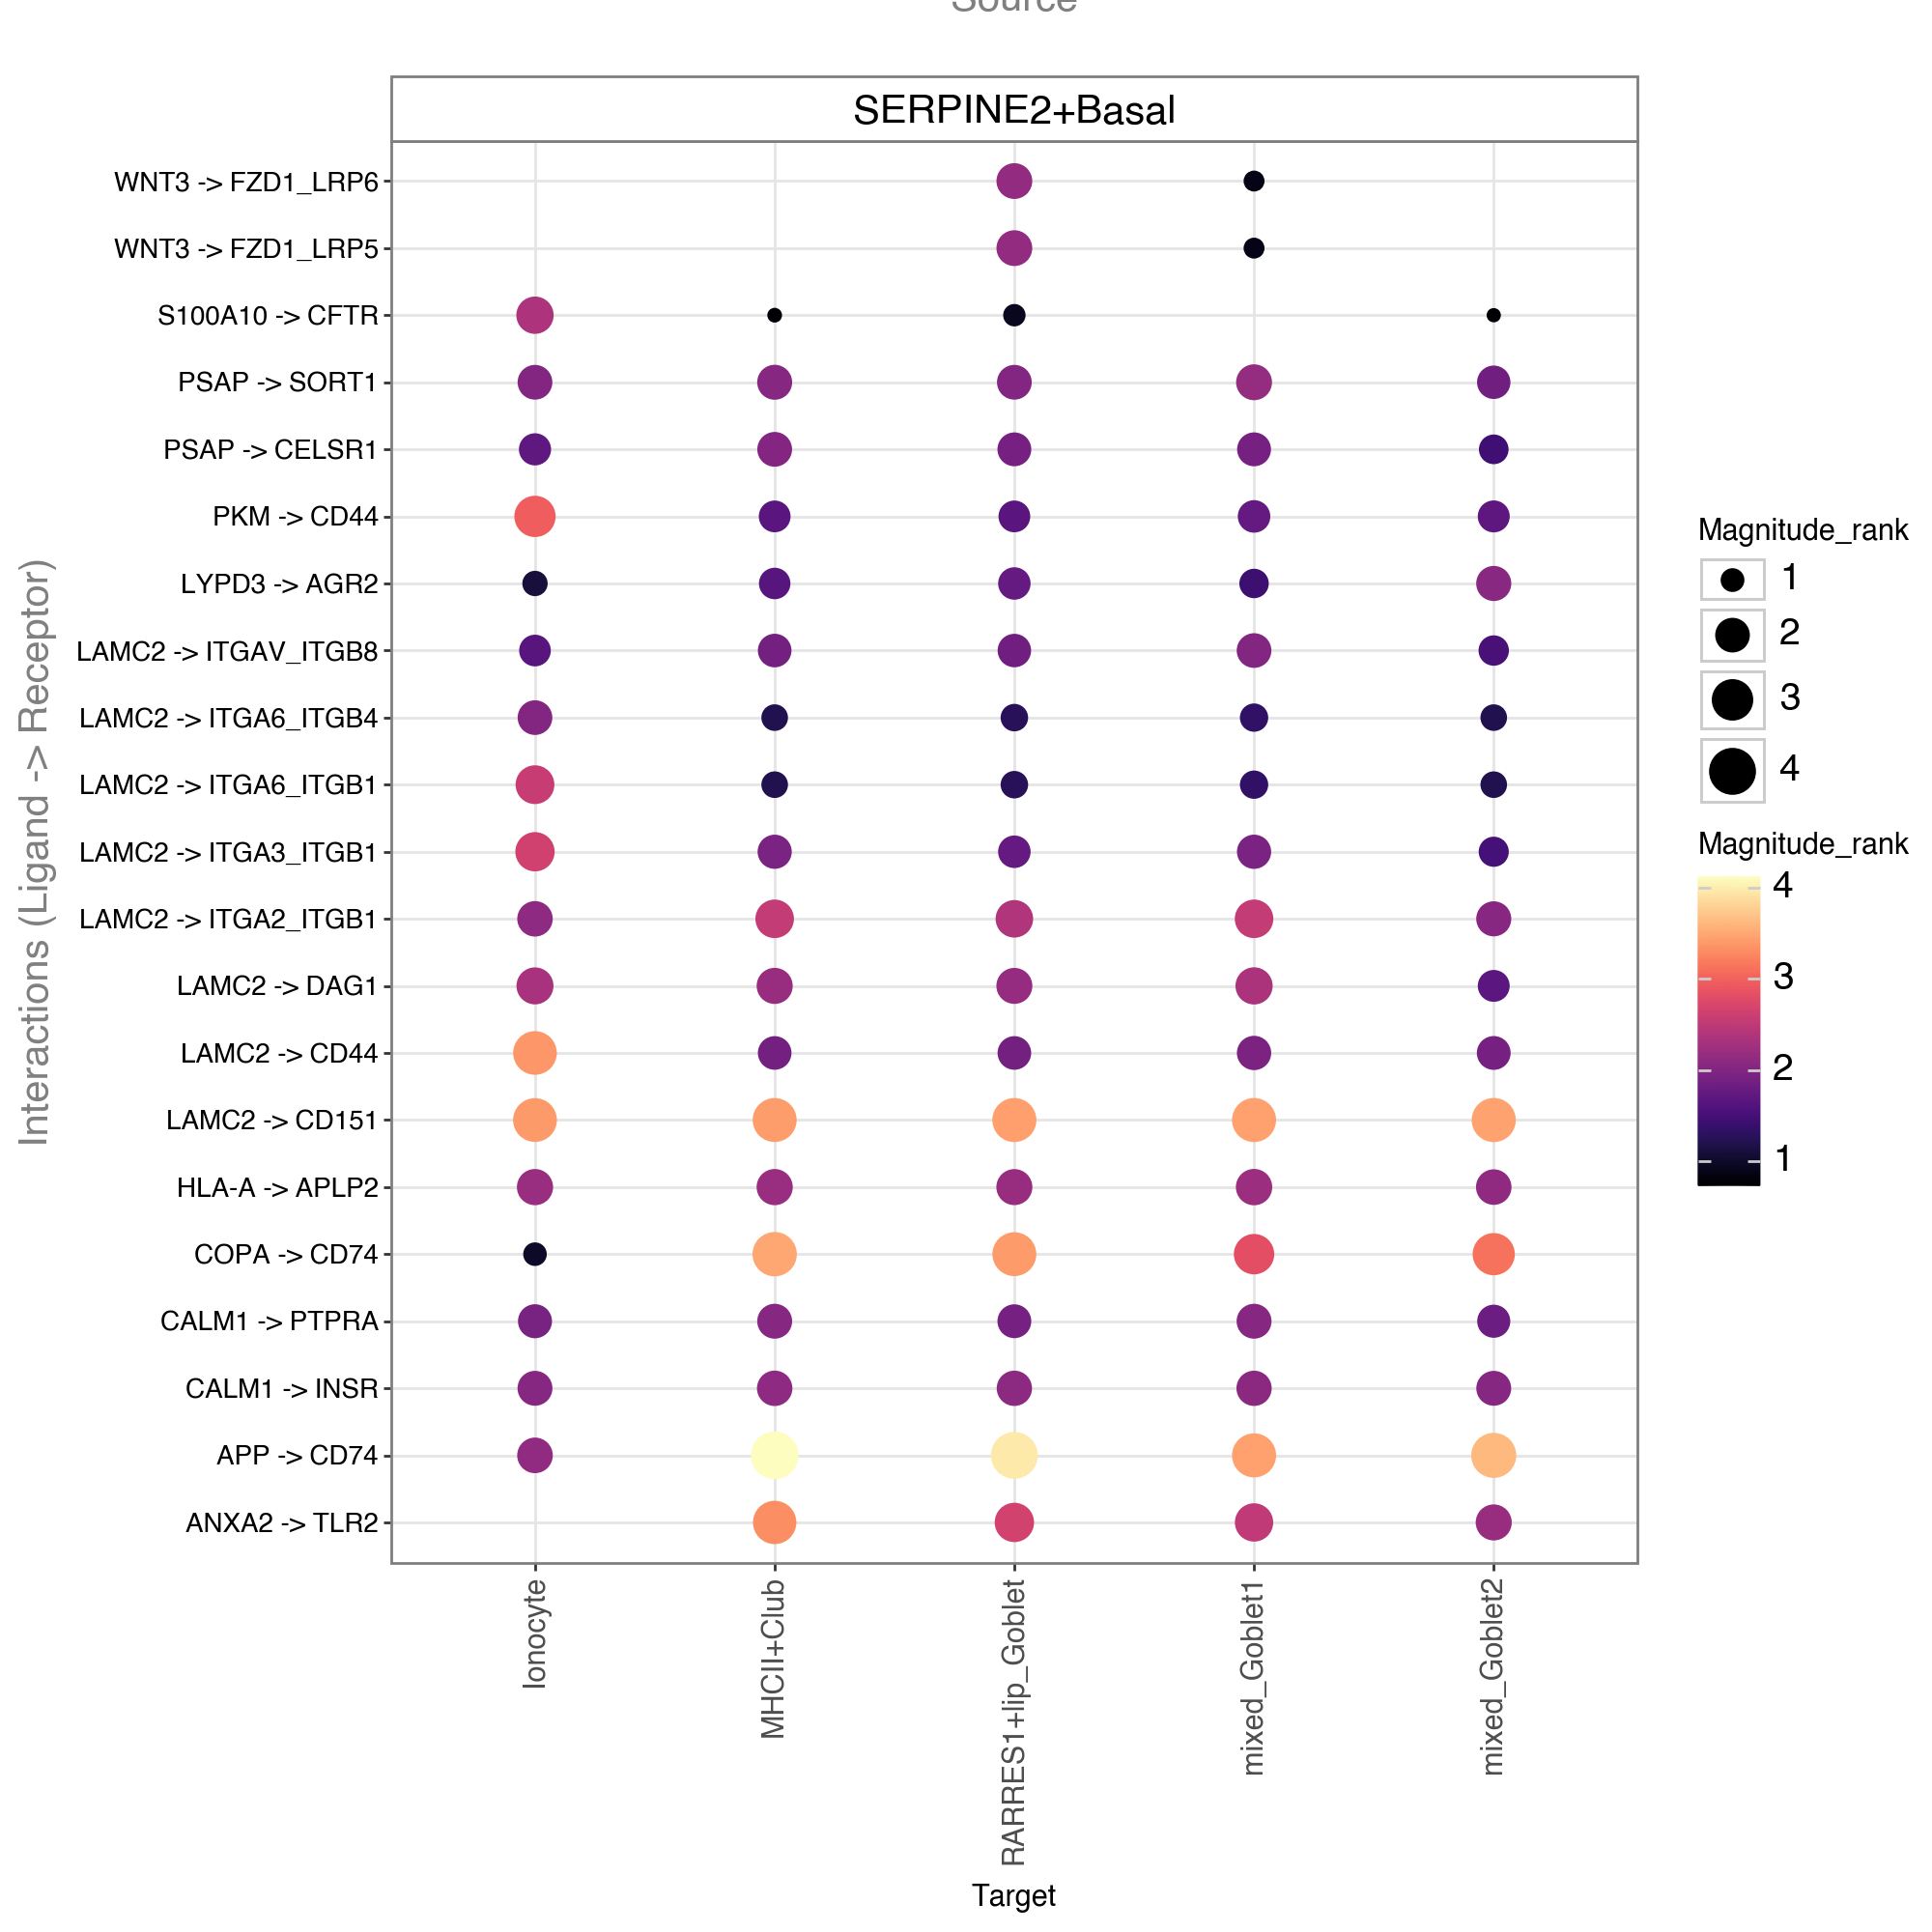

In [8]:
my_plot = li.pl.dotplot(adata = adata,
                        colour='magnitude_rank',
                        inverse_colour = True,
                        size = 'magnitude_rank',
                        inverse_size=False,
                        source_labels=['SERPINE2+Basal'],
                        target_labels = ['RARRES1+lip_Goblet','MHCII+Club', 'Ionocyte', 'mixed_Goblet1', 'mixed_Goblet2'],
                        filter_fun=lambda x: x['magnitude_rank'] <= 0.01,
                        figure_size = (10, 10),
                        cmap = 'magma'
                       )
my_plot

In [9]:
methods = [logfc, geometric_mean]
new_rank_aggregate = li.mt.AggregateClass(li.mt.aggregate_meta, methods=methods)

In [10]:
new_rank_aggregate(adata,
                   groupby='cell_states',
                   expr_prop=0.1,
                   verbose=True,
                   # Note that with this option, we don't perform permutations
                   # and hence we exclude the p-value for geometric_mean, as well as specificity_rank
                   n_perms=None,
                   use_raw=False,
                   )

Using `.X`!
/Users/cartalop/miniforge3/envs/liana+/lib/python3.11/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
105 features of mat are empty, they will be removed.
Make sure that normalized counts are passed!
/Users/cartalop/miniforge3/envs/liana+/lib/python3.11/site-packages/liana/method/_pipe_utils/_pre.py:150: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/Users/cartalop/miniforge3/envs/liana+/lib/python3.11/site-packages/liana/method/_pipe_utils/_pre.py:153: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
['NC_026431.1', 'NC_026432.1', 'NC_026433.1', 'NC_026434.1', 'NC_026435.1', 'NC_026436.1', 'NC_026437.1', 'NC_026438.1'] contain `_`. Consider replacing those!
U

Generating ligand-receptor stats for 22687 samples and 1683 features
Assuming that counts were `natural` log-normalized!


/Users/cartalop/miniforge3/envs/liana+/lib/python3.11/site-packages/liana/method/sc/_liana_pipe.py:266: ImplicitModificationWarning: Setting element `.layers['normcounts']` of view, initializing view as actual.
/Users/cartalop/miniforge3/envs/liana+/lib/python3.11/site-packages/liana/method/sc/_liana_pipe.py:354: RuntimeWarning: overflow encountered in power
/Users/cartalop/miniforge3/envs/liana+/lib/python3.11/site-packages/liana/method/sc/_liana_pipe.py:348: RuntimeWarning: invalid value encountered in subtract
/Users/cartalop/miniforge3/envs/liana+/lib/python3.11/site-packages/liana/method/sc/_liana_pipe.py:348: RuntimeWarning: invalid value encountered in subtract
/Users/cartalop/miniforge3/envs/liana+/lib/python3.11/site-packages/liana/method/sc/_liana_pipe.py:348: RuntimeWarning: invalid value encountered in subtract
/Users/cartalop/miniforge3/envs/liana+/lib/python3.11/site-packages/liana/method/sc/_liana_pipe.py:348: RuntimeWarning: invalid value encountered in subtract
/Users/

Running log2FC


/Users/cartalop/miniforge3/envs/liana+/lib/python3.11/site-packages/numpy/core/_methods.py:118: RuntimeWarning: invalid value encountered in reduce


Running Geometric Mean


In [ ]:
adata.uns['liana_res'].head()